In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Data preprocessing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import pmdarima as pm

## Load dataset

We will be using the [Individual household electric power consumption dataset](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption) from the UCI Machine Learning Repository.</br>

Variables:
*   Global active power: Total active power consumed (kilowatts, kW)
*   Global reactive power: Total reactive power consumed (kW)
*   Voltage: Average voltage (volts, V)
*   Global intensity: Average current intensity (amperes, A)
*   Sub metering 1: Active energy consumed by the kitchen (Watt hours, Wh)
*   Sub metering 2: Active energy consumed by the laundry (Wh)
*   Sub metering 3: Active energy consumed by the water heater and air conditioning/heater (Wh)

In [3]:
# The data are separated using semicolons
# There are numerous values missing, as indicated by 'nan' or '?'
# Abs path in Colab is '/content/drive/MyDrive/Colab Notebooks/household_power_consumption.txt'
df = pd.read_csv('household_power_consumption.txt', 
                 sep=';',
                 low_memory=True, 
                 na_values=['nan','?'], 
                 infer_datetime_format=True, 
                 parse_dates={'datetime':[0,1]})

In [4]:
df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
# Important note: the dataset should contain 2,075,259 rows
# If it does not load completely, you will not be able to successfully complete the analysis below
df.shape

(2075259, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   datetime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [7]:
# Remove non-null but erroneous datetime values and set index to datetime column
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df = df[df['datetime'].notna()]
df = df.set_index('datetime')

In [8]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [9]:
# Replaces nan values with the mean
for i in range(7):        
        df.iloc[:,i]=df.iloc[:,i].fillna(df.iloc[:,i].mean())

In [10]:
# Optional
# Creates a fourth column that represents the remaining Watt hours (Wh) not captured by sub meters 1, 2, or 3
# The kW of global active energy are converted to Wh
submeter_vals = df.values.astype('float32')
df['sub_metering_remainder'] = (submeter_vals[:,0] * 1000 / 60) 
                                - (submeter_vals[:,4] 
                                   + submeter_vals[:,5]
                                   + submeter_vals[:,6])

In [11]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [12]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


## Visualizing the data

In [14]:
# Creates a dataframe that sums the power consumption for each month
monthly_df = df.resample('M').sum()

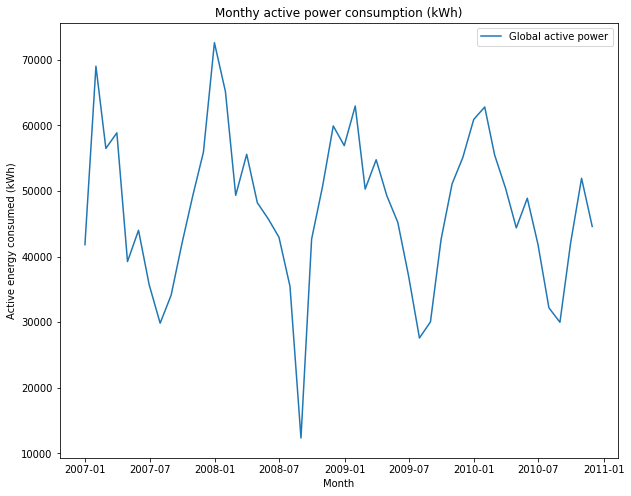

In [15]:
# Plots total monthly power consumption (global active power)
# There is clearly a seasonal component, where consumption peaks in winter and drops in the summer
plt.figure(figsize=(10,8))
plt.plot(monthly_df['Global_active_power'], label='Global active power')
plt.title('Monthy active power consumption (kWh)')
plt.ylabel('Active energy consumed (kWh)')
plt.xlabel('Month')
plt.legend();

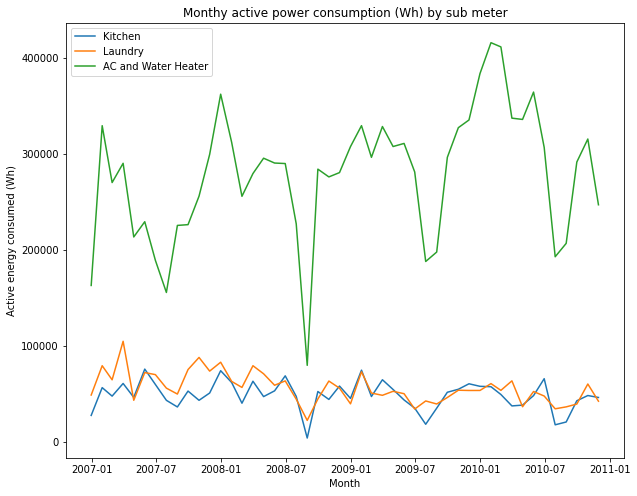

In [16]:
# Plots monthly power consumption by sub meter
plt.figure(figsize=(10,8))
plt.plot(monthly_df['Sub_metering_1'], label='Kitchen')
plt.plot(monthly_df['Sub_metering_2'], label='Laundry')
plt.plot(monthly_df['Sub_metering_3'], label='AC and Water Heater')
plt.title('Monthy active power consumption (Wh) by sub meter')
plt.ylabel('Active energy consumed (Wh)')
plt.xlabel('Month')
plt.legend();

In [17]:
# Creates a dataframe that finds the mean power consumption by hour
df['datetime'] = df.index
hourly_df = df.groupby(df['datetime'].dt.hour).mean()
hourly_test = df.resample('H').mean()

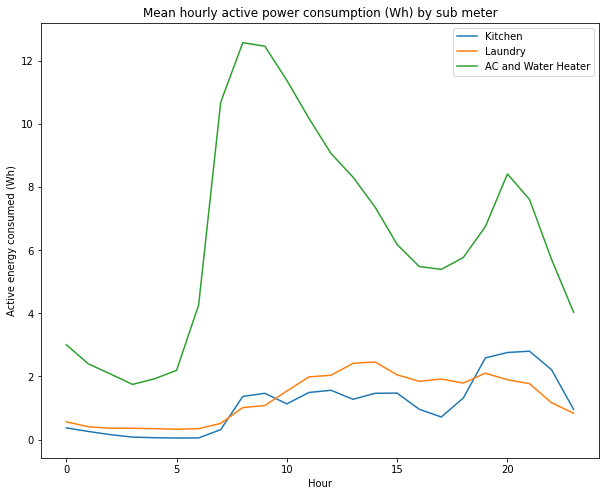

In [18]:
# Plots the mean hourly active power consumption by sub meter
plt.figure(figsize=(10,8))
plt.plot(hourly_df['Sub_metering_1'], label='Kitchen')
plt.plot(hourly_df['Sub_metering_2'], label='Laundry')
plt.plot(hourly_df['Sub_metering_3'], label='AC and Water Heater')
plt.title('Mean hourly active power consumption (Wh) by sub meter')
plt.ylabel('Active energy consumed (Wh)')
plt.xlabel('Hour')
plt.legend();

In [19]:
# Creates a new dataframe that resamples by day
daily_df = df.resample('D').sum()
daily_df = daily_df[['Global_active_power', 
                     'Sub_metering_1', 
                     'Sub_metering_2', 
                     'Sub_metering_3']]

In [ ]:
# Creates a dataframe just for global active power
daily_df_g = pd.DataFrame(daily_df['Global_active_power'])

In [20]:
daily_df = daily_df.melt()
submeter_df = daily_df[daily_df['variable'] != 'Global_active_power']

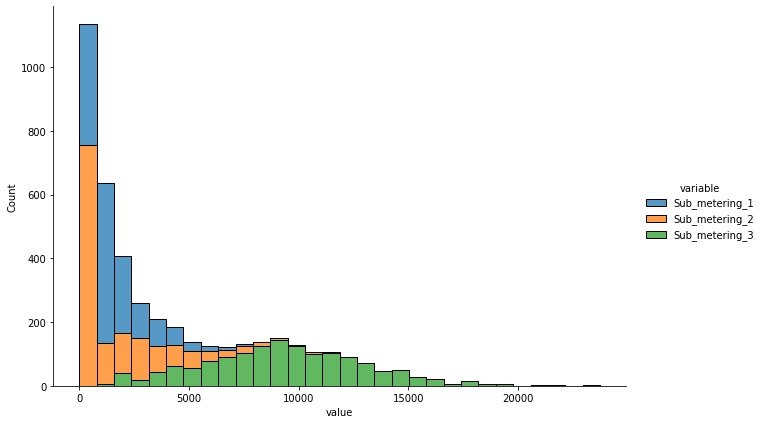

In [21]:
sns.displot(submeter_df, 
            x='value', 
            hue='variable',
            height=6,
            multiple='stack',
            aspect=1.5, 
            legend=True);

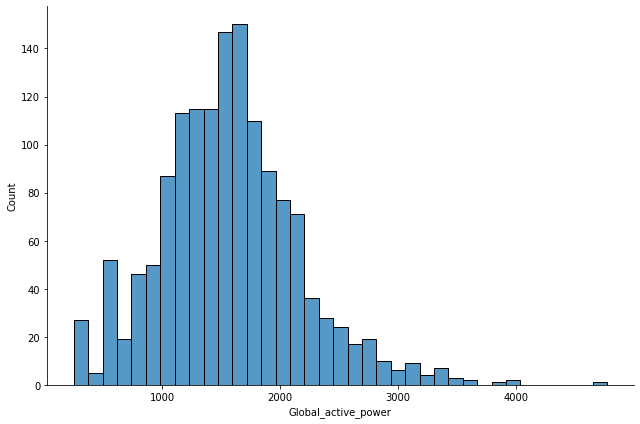

In [22]:
sns.displot(daily_df_g, 
            x='Global_active_power', 
            height=6,
            aspect=1.5);

## K-means clustering to identify different power usage patterns of the household

In [23]:
# Creates a new dataframe that resamples by hour and pivots on hour
pivot_df = df.resample('H').sum()
pivot_df['hour'] = pivot_df.index.hour
pivot_df.index = pivot_df.index.date
pivot_df = pivot_df[['Global_active_power', 'hour']]
pivot_df = pivot_df.pivot(columns='hour', values='Global_active_power')
pivot_df = pivot_df.dropna()
pivot_df.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2006-12-17,112.948,200.964,95.236,99.732,132.946,119.804,78.198,97.202,113.434,152.944,...,125.558,179.124,199.562,204.406,221.826,174.504,201.690,182.446,91.080,26.264
2006-12-18,16.582,18.798,17.068,18.596,61.580,17.610,36.600,147.026,124.928,97.760,...,103.982,107.058,116.958,129.294,144.152,156.870,183.034,130.184,104.328,92.836
2006-12-19,50.228,21.182,19.634,18.498,19.670,18.400,47.780,107.138,232.742,97.066,...,18.128,25.282,82.328,126.690,132.282,110.526,176.432,86.572,43.200,23.022
2006-12-20,27.590,15.520,47.062,18.602,17.340,15.762,17.016,91.598,175.056,83.132,...,77.694,16.868,28.106,34.410,170.210,194.918,214.528,218.764,183.538,142.906
2006-12-21,92.152,83.878,76.494,18.156,14.804,17.442,17.740,76.828,93.782,154.548,...,61.434,18.444,81.604,105.158,146.598,131.828,146.242,58.936,16.816,16.226


In [24]:
# Instantiates a K-means clustering object with three clusters
# 3 clusters was determined to the optimal number using the elbow method
# Random state is used to keep the arbitrary cluster numbers the same each run
# K-means identifies the same three clusters regardless of random state
seed = 42
kmeans = KMeans(n_clusters=3, random_state=seed)

# Scale values prior to K-means clustering
X = pivot_df.values.copy()
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [25]:
# Predicts the cluster for each value in X
clusters = kmeans.fit_predict(X)
clusters_series = pd.Series(clusters, name='cluster')
pivot_df = pivot_df.set_index(clusters_series, append=True)

In [26]:
pivot_df.head()

,hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
,cluster,,,,,,,,,,,,,,,,,,,,,
2006-12-17,0,112.948,200.964,95.236,99.732,132.946,119.804,78.198,97.202,113.434,152.944,...,125.558,179.124,199.562,204.406,221.826,174.504,201.690,182.446,91.080,26.264
2006-12-18,0,16.582,18.798,17.068,18.596,61.580,17.610,36.600,147.026,124.928,97.760,...,103.982,107.058,116.958,129.294,144.152,156.870,183.034,130.184,104.328,92.836
2006-12-19,2,50.228,21.182,19.634,18.498,19.670,18.400,47.780,107.138,232.742,97.066,...,18.128,25.282,82.328,126.690,132.282,110.526,176.432,86.572,43.200,23.022
2006-12-20,2,27.590,15.520,47.062,18.602,17.340,15.762,17.016,91.598,175.056,83.132,...,77.694,16.868,28.106,34.410,170.210,194.918,214.528,218.764,183.538,142.906
2006-12-21,2,92.152,83.878,76.494,18.156,14.804,17.442,17.740,76.828,93.782,154.548,...,61.434,18.444,81.604,105.158,146.598,131.828,146.242,58.936,16.816,16.226


In [27]:
# Displays the K-means score, which is the opposite of the inertia
print(f'The K-means score is {round(kmeans.score(X), 2)}')

The K-means score is -617.23


In [28]:
# Plots power usage patterns by K-means cluster
# Colors correspond to different clusters
# The thick lines represent the median global active energy for each cluster
# If daily_plot=True, faint lines represent each day's global active energy
def plot_clusters(pivot_df, daily_plot=True):
    fig, ax= plt.subplots(1,1, figsize=(12,8))
    color_list = ['b','g','r']
    cluster_values = sorted(pivot_df.index.get_level_values('cluster').unique())
    # Uses a cross-section of the dataframe for each cluster to generate plots
    for cluster, color in zip(cluster_values, color_list):
        if daily_plot:
            pivot_df.xs(cluster, level=1).T.plot(
                ax=ax, legend=False, alpha=0.01, color=color, label= f'Cluster {cluster}'
                )
        pivot_df.xs(cluster, level=1).median().plot(
            ax=ax, label= f'Cluster {cluster+1}', legend=True, color=color, alpha=0.9
        )
    
    ax.set_xticks(np.arange(0,24))
    ax.set_title('Power Usage Patterns (3 clusters)')
    ax.set_ylabel('Global Active Energy (kW)')
    ax.set_xlabel('Hour');

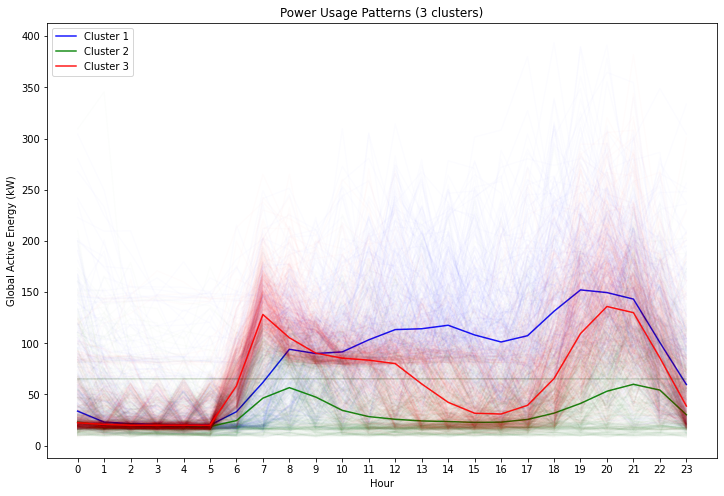

In [29]:
plot_clusters(pivot_df)

Possible interpretations of the three usage patterns shown above:
- Blue (cluster 1): Relatively high and consistent global active energy usage during waking hours. May represent a household where one or more residents work from home.
- Green (cluster 2): Relatively low global active energy throughout the day, with small peaks in the morning and evening. May represent times when residents were away from home for the entire day.
- Red (cluster 3): Global active energy peaks in the morning, drops in the afternoon, and peaks again in the evening. May represent a household where one or more residents commute to the office.

## Forecasting with ARIMA

Using the Box-Jenkins approach, I developed a simple regressive model that predicts global active power by month.
- Reuse monthly_df, a resampled dataframe that sums by month
- Use seasonal_decompose to visualize trends, seasonalities, and irregularities
- Check autocorrelation and partial autocorrelation
- Use Auto Regressive Integrated Moving Average (ARIMA) to predict next month's consumption patterns

In [30]:
montly_df = df.resample('M').sum()

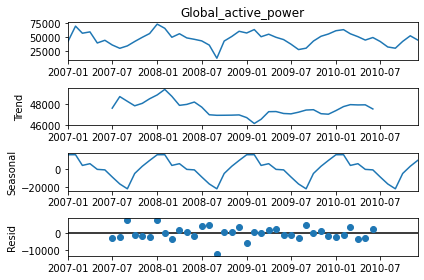

In [31]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(monthly_df['Global_active_power'], model='additive')
result_add.plot();

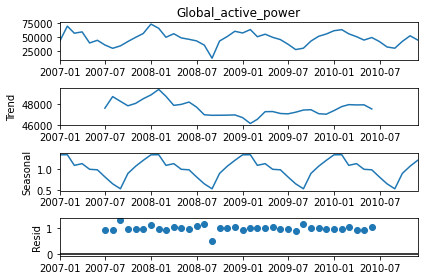

In [32]:
# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
result_multi = seasonal_decompose(monthly_df['Global_active_power'], model='multiplicative')
result_multi.plot();

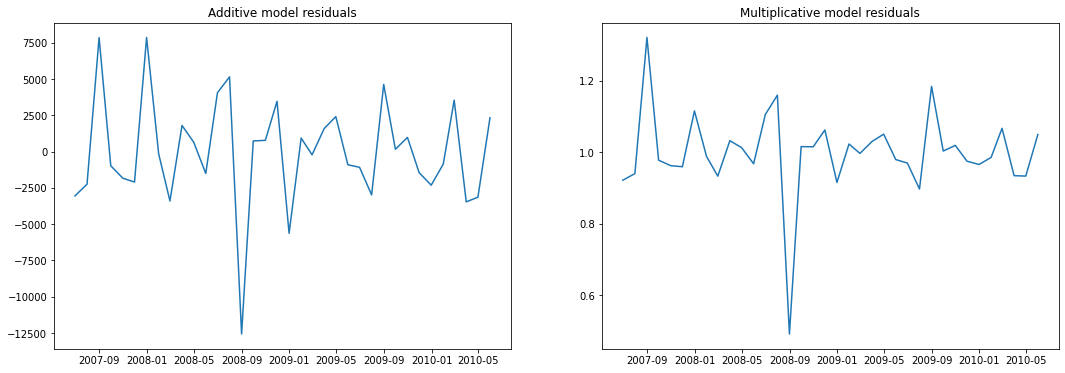

In [33]:
# Plot the residuals to visually assess stationarity
f, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
ax1.plot(result_add.resid)
ax1.set_title("Additive model residuals")
ax2.plot(result_multi.resid)
ax2.set_title("Multiplicative model residuals");

In [34]:
# Augmented Dickey-Fuller (ADF) test for stationarity
# p<0.05 suggests stationarity
# Multiplicative model is stationary, but additive is not
print('p-value for additive model: ', adfuller(result_add.resid.dropna())[1])
print('p-value for multiplicative model: ', adfuller(result_multi.resid.dropna())[1])

p-value for additive model:  0.16405393200288954
p-value for multiplicative model:  4.510763619515112e-08


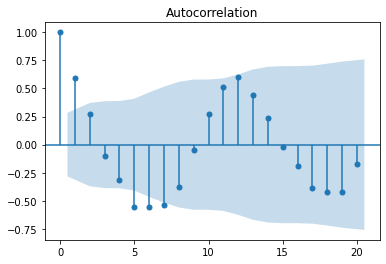

In [35]:
# Plots the autocorrelation of each observation at a given lag
# The ACF falls within the confidence interval around 2 lags
plot_acf(monthly_df['Global_active_power'], lags=20)
plt.show()

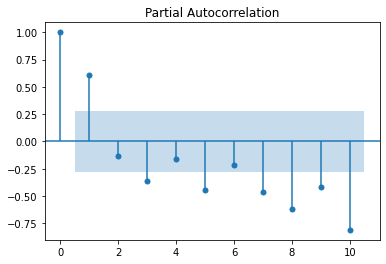

In [36]:
# Plots the partial autocorrelation, removing indirect effects
# The PACF falls within the confidence interval around 2 lags
plot_pacf(monthly_df['Global_active_power'], lags=10)
plt.show();

In [37]:
# Quick check to see whether the log likelihood and AIC are reasonable with order (2,0,2)
# Not the final ARIMA model
arima = ARIMA(monthly_df['Global_active_power'], order=(2,0,2), enforce_stationarity=False)
arima = arima.fit()
arima.summary()

/home/elizabeth/.pyenv/versions/3.8.12/envs/personal/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Global_active_power   No. Observations:                   48
Model:                  ARIMA(2, 0, 2)   Log Likelihood                -461.189
Date:                 Tue, 25 Jan 2022   AIC                            934.378
Time:                         12:46:20   BIC                            945.218
Sample:                     12-31-2006   HQIC                           938.419
                          - 11-30-2010                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.72e+04    757.848     62.276      0.000    4.57e+04    4.87e+04
ar.L1          1.7162      0.068     25.342      0.000       1.583       1.849
ar.L2         -0.9673      0.060    -16.239      0.000      -1.084      -0.851
ma.L1         -1.5211      0.144    -10.573      0.000      -1.803      -1.239
ma.L2          0.6307      0.173      3.640      0.000       0.291       0.970
sigma2      5.966e+07      0.010   5.87e+09      0.000    5.97e+07    5.97e+07
===================================================================================
Ljung-Box (Q):                       38.55   Jarque-Bera (JB):                 5.34
Prob(Q):                              0.54   Prob(JB):                         0.07
Heteroskedasticity (H):               0.43   Skew:                            -0.54
Prob(H) (two-sided):                  0.12   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.96e+25. Standard errors may be unstable.
"""

In [38]:
# Create a 70/30 train/test split from monthly_df
print(f'Original dataframe shape: {monthly_df.shape}')
train = monthly_df['Global_active_power'][0:34]
test = monthly_df['Global_active_power'][34:]
print(f'Train shape: {train.shape}')
print(f'Testsmape: {test.shape}')

Original dataframe shape: (48, 7)
Train shape: (34,)
Testsmape: (14,)


In [39]:
arima = ARIMA(train, order=(2, 0, 2), enforce_stationarity=False)  
arima = arima.fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Global_active_power   No. Observations:                   34
Model:                  ARIMA(2, 0, 2)   Log Likelihood                -321.237
Date:                 Tue, 25 Jan 2022   AIC                            654.473
Time:                         12:46:20   BIC                            663.077
Sample:                     12-31-2006   HQIC                           657.278
                          - 09-30-2009                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.688e+04   1286.625     36.433      0.000    4.44e+04    4.94e+04
ar.L1          1.7243      0.092     18.675      0.000       1.543       1.905
ar.L2         -0.9780      0.083    -11.814      0.000      -1.140      -0.816
ma.L1         -1.4890      0.204     -7.307      0.000      -1.888      -1.090
ma.L2          0.6228      0.242      2.574      0.010       0.149       1.097
sigma2      7.656e+07      0.017   4.62e+09      0.000    7.66e+07    7.66e+07
===================================================================================
Ljung-Box (Q):                       27.42   Jarque-Bera (JB):                 3.58
Prob(Q):                              0.60   Prob(JB):                         0.17
Heteroskedasticity (H):               0.46   Skew:                            -0.67
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.65e+26. Standard errors may be unstable.
"""

/home/elizabeth/.pyenv/versions/3.8.12/envs/personal/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


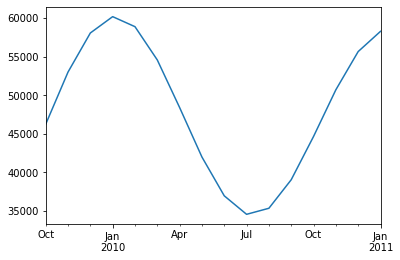

In [40]:
# Predicts global active power for the test data
# Forecasts two additional months beyond the test data
forecast = arima.get_prediction(start='2009-10-31', end='2011-1-31', alpha=0.05)
forecast.predicted_mean.plot();

In [41]:
# Stores the confidence intervals for each date (CI=95%)
confidence_int = forecast.conf_int(alpha=0.05)

In [42]:
# Plots the training, test, and forecasted values with CI
def plot_forecast(forecast, train, test, upper, lower):
    lower_series = pd.Series(upper, index=forecast.index) 
    upper_series = pd.Series(lower, index=forecast.index)
    plt.figure(figsize=(12,6))
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(forecast, label='forecast', color='b')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.05)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

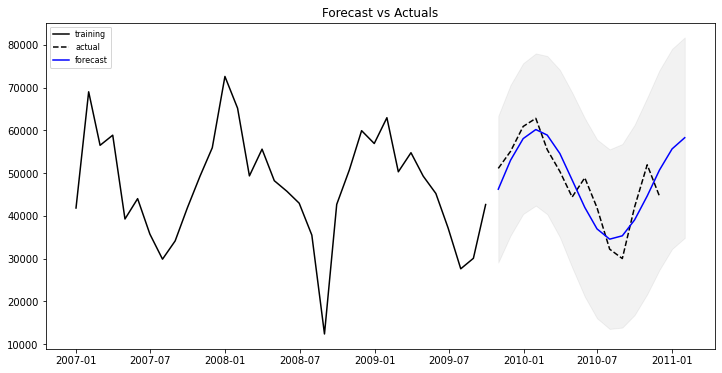

In [43]:
plot_forecast(forecast.predicted_mean, 
              train, test, 
              confidence_int['lower Global_active_power'], 
              confidence_int['upper Global_active_power'])

In [44]:
mse = mean_squared_error(forecast.predicted_mean[:14], test)
rmse = np.sqrt(mse)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MSE: 21009816.83238968
RMSE: 4583.646674034734


## Estimating Scope 2 Greenhouse Gas Emissions

Scope 2 emissions are indirect GHG emissions associated with the purchase of electricity, steam, heat, or cooling.</br>
The data are gathered from a household in France. For the sake of this exercise, we will use the International Energy Agency (IEA) emission factors for Europe as a whole. Japan-specific emission factors were included for comparison.
Sources:
- [GHG Protocol Scope 2 Guidance](https://ghgprotocol.org/sites/default/files/standards/Scope%202%20Guidance_Final_Sept26.pdf)
- [National Greenhouse Gas Inventory Report of JAPAN](https://www.env.go.jp/earth/ondanka/ghg-mrv/unfccc/material/NIR-JPN-2017_E.pdf)
- [Greenhouse Gas Inventory Guidance](https://www.epa.gov/sites/default/files/2020-12/documents/electricityemissions.pdf)
- [Electricity-specific emission factors for grid electricity](https://ecometrica.com/assets/Electricity-specific-emission-factors-for-grid-electricity.pdf)

In [45]:
# Emission factors (ef) are emissions per kWh of electricity consumed (kg GHG/kWh)
# The global warming potentials (GWPs) for each GHG are used to calculate CO2-equivalent emissions
iea_europe = {
    'CO2_ef': 0.501906383,
    'CH4_ef': 0.00000629978,
    'N2O_ef': 0.00000587156,
    'CO2_gwp': 1,
    'CH4_gwp': 25,
    'N2O_gwp': 298
}

In [46]:
iea_japan = {
    'CO2_ef': 0.465951477,
    'CH4_ef': 0.00000746038,
    'N2O_ef': 0.00000416633,
    'CO2_gwp': 1,
    'CH4_gwp': 25,
    'N2O_gwp': 298
}

In [47]:
# Creates a dataframe with the calculations for Scope 2 emissions
# Requires a dictionary with emission factors and global warming potentials
# CO2 equivalents are given in metric tons
def calculate_emissions(df, iea_dict):
    df = pd.DataFrame(df['Global_active_power'])
    df['CO2_ef'] = df['Global_active_power'] * iea_dict['CO2_ef']
    df['CH4_ef'] = df['Global_active_power'] * iea_dict['CH4_ef']
    df['N2O_ef'] = df['Global_active_power'] * iea_dict['N2O_ef']
    df['CH4_gwp'] = df['CH4_ef'] * iea_dict['CH4_gwp']
    df['N2O_gwp'] = df['N2O_ef'] * iea_dict['N2O_gwp']
    df['CO2_eq'] = (df['CO2_ef'] + df['CH4_gwp'] + df['N2O_gwp']) / 1000
    return df

In [48]:
europe_df = calculate_emissions(monthly_df, iea_europe)
europe_df.head()

,Global_active_power,CO2_ef,CH4_ef,N2O_ef,CH4_gwp,N2O_gwp,CO2_eq
datetime,,,,,,,
2006-12-31,41817.648460,20988.544684,0.263442,0.245535,6.586050,73.169380,21.068300
2007-01-31,69014.045230,34638.589818,0.434773,0.405220,10.869333,120.755592,34.770215
2007-02-28,56491.069230,28353.228229,0.355881,0.331691,8.897033,98.843829,28.460969
2007-03-31,58863.283615,29543.857771,0.370826,0.345619,9.270643,102.994552,29.656123
2007-04-30,39245.548781,19697.591437,0.247238,0.230433,6.180958,68.668913,19.772441


In [49]:
japan_df = calculate_emissions(monthly_df, iea_japan)
japan_df.head()

,Global_active_power,CO2_ef,CH4_ef,N2O_ef,CH4_gwp,N2O_gwp,CO2_eq
datetime,,,,,,,
2006-12-31,41817.648460,19484.995065,0.311976,0.174226,7.799389,51.919385,19.544714
2007-01-31,69014.045230,32157.196309,0.514871,0.287535,12.871775,85.685516,32.255754
2007-02-28,56491.069230,26322.097145,0.421445,0.235360,10.536121,70.137410,26.402771
2007-03-31,58863.283615,27427.433941,0.439142,0.245244,10.978562,73.082672,27.511495
2007-04-30,39245.548781,18286.521420,0.292787,0.163510,7.319668,48.725952,18.342567


In [50]:
def plot_emissions(df):
    plt.figure(figsize=(12,6))
    plt.plot(df['CO2_eq'], label='CO2 equivalents', color='b')
    plt.legend(loc='upper left', fontsize=8)
    plt.title('Scope 2 Greenhouse Gas Emissions')
    plt.ylabel('CO2 equivalents (metric ton)')
    plt.xlabel('Month');

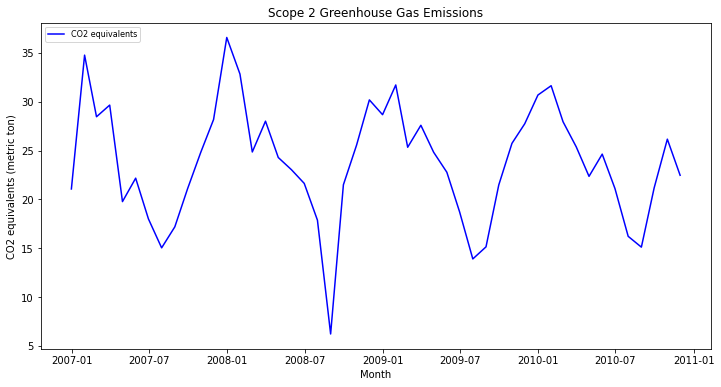

In [51]:
plot_emissions(europe_df)

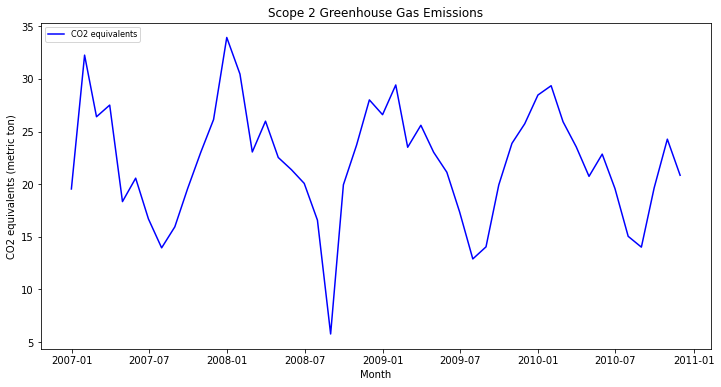

In [52]:
plot_emissions(japan_df)